In [1]:
################################
# Scientific imports
################################
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs

###
# General imports
###
import csv, math, io, os, os.path, sys, random, time
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

###
# SciKitLearn Imports
###
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from IPython.display import display

###
# MatPlotLib Settings
###

plt.rcParams["figure.figsize"] = (20,9)
sb.set()


################################
# Initialisers
################################

def INITIALISE():
    # Load the Data files
    fitsarr = np.load("fitslist.npy")
    fluxarr = np.load("fluxlist.npy")
    #planetarr = np.load("planetlist.npy")
    isplanetarr = np.load("isplanetlist.npy")

In [2]:
plt.rcParams["figure.figsize"] = (8,6)

8925


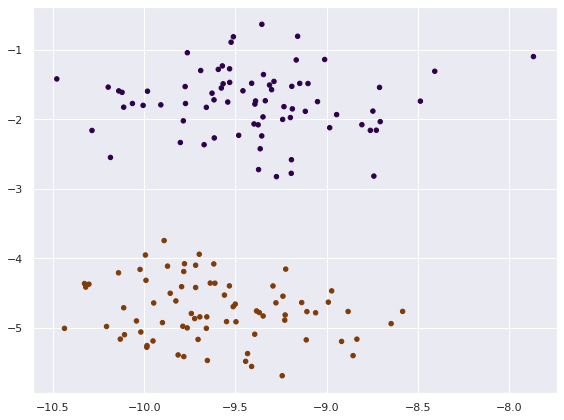

In [60]:
#RND = int(random.random()*9999)
RND = 8925
print(RND)

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150, centers=2,
                  random_state=RND, cluster_std=0.45)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');

#plt.ylim(-1,8)
#plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('img/svm-ex.png')

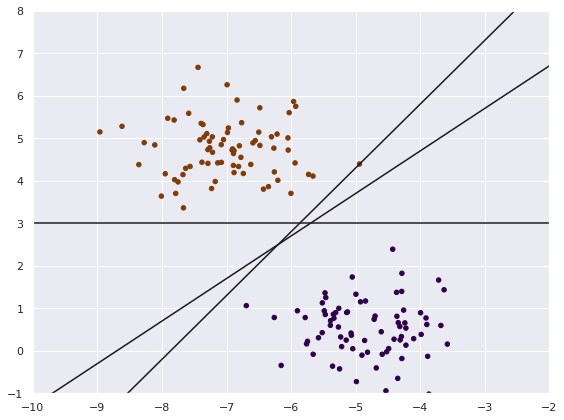

In [13]:
xfit = np.linspace(-10, 0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1.5, 11.8), (1, 8.7), (0, 3)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')

plt.ylim(-1,8)
plt.xlim(-10,-2)

plt.tight_layout()
#plt.savefig('img/svm-2.png')

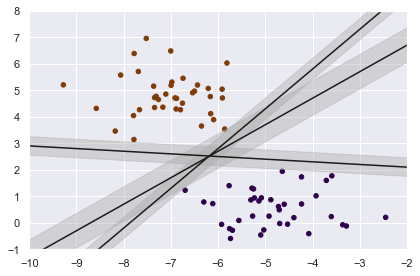

In [253]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr');
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b, d in [(1.5, 11.8, 0.4), (1, 8.7, 0.65), (-0.1, 1.9, 0.35)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.ylim(-1,8)
plt.xlim(-10,-2)

plt.tight_layout()
plt.savefig('imgs/svm-3.png')

In [254]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [284]:
def plot_svc_decision_function(model, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=1, linewidth=20, facecolors='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

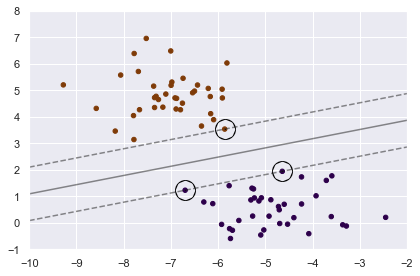

In [286]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='PuOr')
plt.ylim(-1,8)
plt.xlim(-10,-2)
#plt.ylim(1,2)
#plt.xlim(-7,-6.5)
plt.tight_layout()

plot_svc_decision_function(model);

plt.savefig('imgs/svm-4.png')

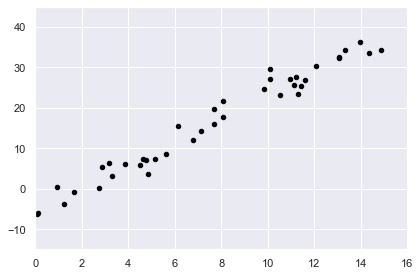

In [352]:
# y = 3x-6

rng = np.random.RandomState(14)
npts = 40

x = 15 * rng.rand(npts)
y = 3 * x - 6 + (2*rng.randn(npts))
plt.xlim(0,16)
plt.ylim(-15,45)
plt.tight_layout()
plt.scatter(x, y, s=20, c="black");

plt.savefig('imgs/linreg-1.png')

Finding out what the Newsgroups are in the Naive-Bayes example in Python handbook (and how large they are)

In [354]:
from sklearn.datasets import fetch_20newsgroups

In [360]:
data = fetch_20newsgroups()
data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [363]:
print(len(data.filenames))
data.filenames

11314


array(['/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/rec.autos/102994',
       '/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51861',
       '/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.mac.hardware/51879',
       ...,
       '/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/comp.sys.ibm.pc.hardware/60695',
       '/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38319',
       '/home/jdowzell/scikit_learn_data/20news_home/20news-bydate-train/rec.motorcycles/104440'],
      dtype='<U95')

In [364]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

In [375]:
print(train.data[0])

From: jono@mac-ak-24.rtsg.mot.com (Jon Ogden)
Subject: Re: Losing your temper is not a Christian trait
Organization: Motorola LPA Development
Lines: 26

In article <Apr.23.02.55.47.1993.3138@geneva.rutgers.edu>, jcj@tellabs.com
(jcj) wrote:

> I'd like to remind people of the withering of the fig tree and Jesus
> driving the money changers et. al. out of the temple.  I think those
> were two instances of Christ showing anger (as part of His human side).
> 
Yes, and what about Paul saying:

26 Be ye angry, and sin not: let not the sun go down upon your wrath:
(Ephesians 4:26).

Obviously then, we can be angry w/o sinning.

Jon

------------------------------------------------
Jon Ogden         - jono@mac-ak-24.rtsg.mot.com
Motorola Cellular - Advanced Products Division
Voice: 708-632-2521      Data: 708-632-6086
------------------------------------------------

They drew a circle and shut him out.
Heretic, Rebel, a thing to flout.
But Love and I had the wit to win;
We drew a circle and 

In [376]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [377]:
model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [378]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

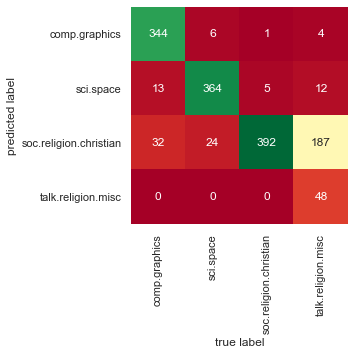

In [385]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sb.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="RdYlGn",
            xticklabels=train.target_names, yticklabels=train.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [386]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

In [399]:
phrase="i want my laptop fixed"

predict_category(phrase)

'soc.religion.christian'

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.bar([0,1,2,3,4,5,6],[0.6,0.23,0.65,0.78,0.11,0.05,0.99],tick_label=['SVM','SVM_FFT','RT','RT_FFT','NB','BN_FFT','ETC'])
plt.title("Bar graph of the Accuracy Values of the several Machine Learning methods", fontsize=18)
plt.savefig('img/examplemetrics.png')